In [2]:
#### Imports ####
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.pyplot import imshow, show, subplot,title,axis
from matplotlib.patches import Circle
from skimage.io import imread
from skimage import img_as_float,img_as_ubyte
from skimage.color import rgb2hsv,hsv2rgb,rgb2gray
import skimage.util
import skimage as sk
import scipy
import scipy.ndimage
import scipy.signal
import scipy.signal as signal
from scipy.signal import convolve,gaussian
from scipy.signal import convolve2d
from timeit import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy import ndimage
from skimage.feature import corner_peaks,peak_local_max
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import os
from skimage import exposure, filters, morphology
from cellpose import models, io, denoise
from cellpose.io import imread, logger_setup

In [3]:
def compute_cdf(histogram):
    # Compute the cumulative sum of the histogram
    cumulative_histogram = np.cumsum(histogram)
    # Normalize the cumulative histogram to obtain the CDF
    cdf = cumulative_histogram / np.sum(histogram)
    return cdf

def C(image, cdf):
    c = cdf[image]
    return c

def custom_colormap():
    n_intervals = 10
    intervals = np.linspace(0, 1, n_intervals)
    cmap_dict = {'red': [], 'green': [], 'blue': []}
    for interval in intervals:
        r = 1  # Max intensity (red)
        g = 0  # Min intensity (green)
        b = 0  # Min intensity (blue)
        cmap_dict['red'].append((interval, r, r))
        cmap_dict['green'].append((interval, g, g))
        cmap_dict['blue'].append((interval, b, b))
    custom_cmap = LinearSegmentedColormap('custom', cmap_dict)
    return custom_cmap

In [8]:
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        img = imread(image_path)
        if img is not None:
            images.append(img)
        else:
            print(f"Error loading image {filename}")
    return images

path = r"./image/control"
# path = r"./image/penetramax"
Images = load_images_from_folder(path)

creating new log file
2024-05-27 14:54:22,372 [INFO] WRITING LOG OUTPUT TO /home/amaschio/.cellpose/run.log
2024-05-27 14:54:22,373 [INFO] 
cellpose version: 	3.0.8 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.2.2+cu118
2024-05-27 14:54:22,374 [INFO] Downloading: "https://www.cellpose.org/models/denoise_nuclei" to /home/amaschio/.cellpose/models/denoise_nuclei



100%|██████████| 25.3M/25.3M [00:05<00:00, 4.84MB/s]

2024-05-27 14:54:28,724 [INFO] >> denoise_nuclei << model set to be used


2024-05-27 14:54:28,950 [INFO] ** TORCH CUDA version installed and working. **
2024-05-27 14:54:28,951 [INFO] >>>> using GPU
2024-05-27 14:54:29,220 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-05-27 14:54:29,222 [INFO] >> nuclei << model set to be used
2024-05-27 14:54:29,223 [INFO] Downloading: "https://www.cellpose.org/models/nucleitorch_0" to /home/amaschio/.cellpose/models/nucleitorch_0



100%|██████████| 25.3M/25.3M [00:02<00:00, 10.1MB/s]

2024-05-27 14:54:32,607 [INFO] ** TORCH CUDA version installed and working. **
2024-05-27 14:54:32,608 [INFO] >>>> using GPU


2024-05-27 14:54:32,741 [INFO] >>>> loading model /home/amaschio/.cellpose/models/nucleitorch_0
2024-05-27 14:54:32,860 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)


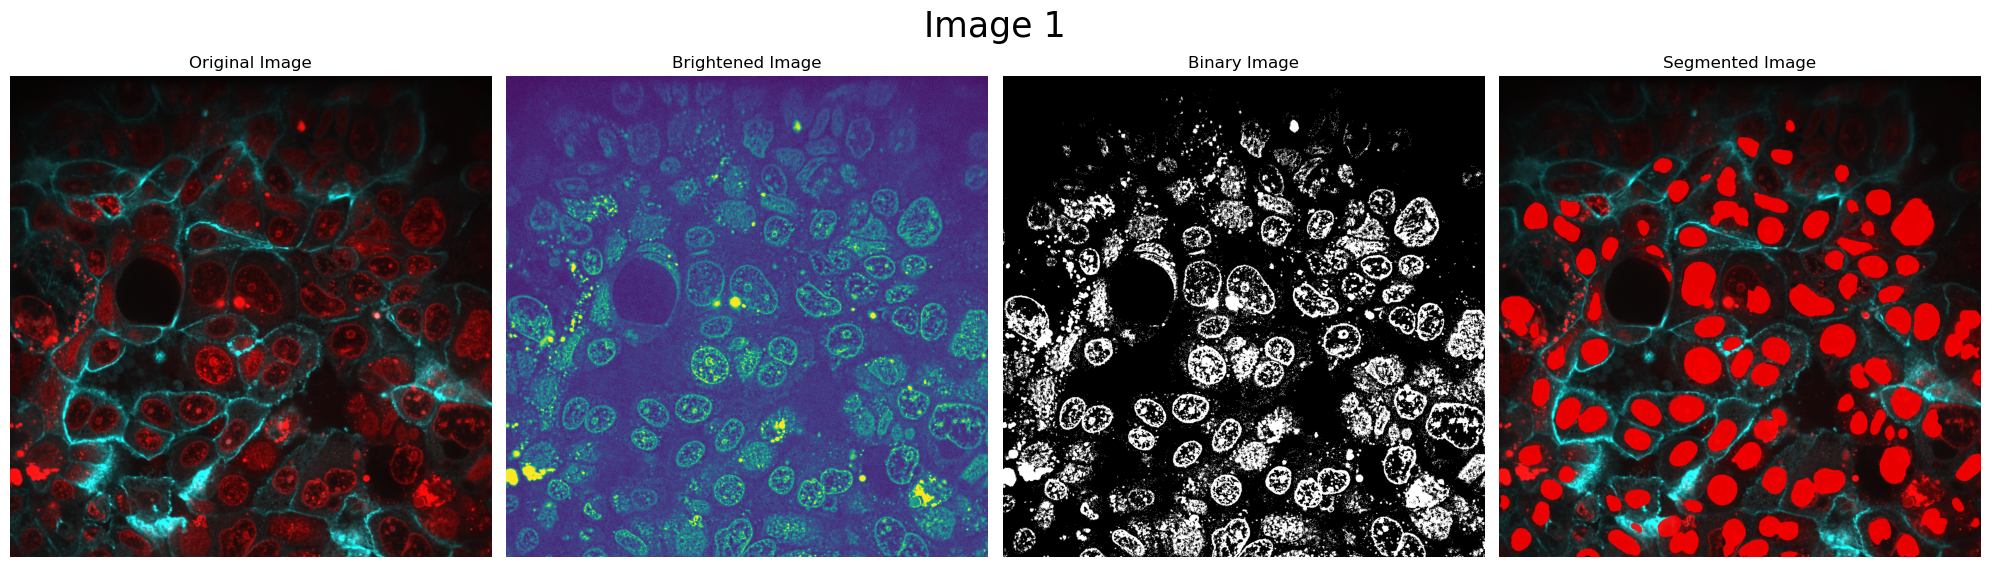

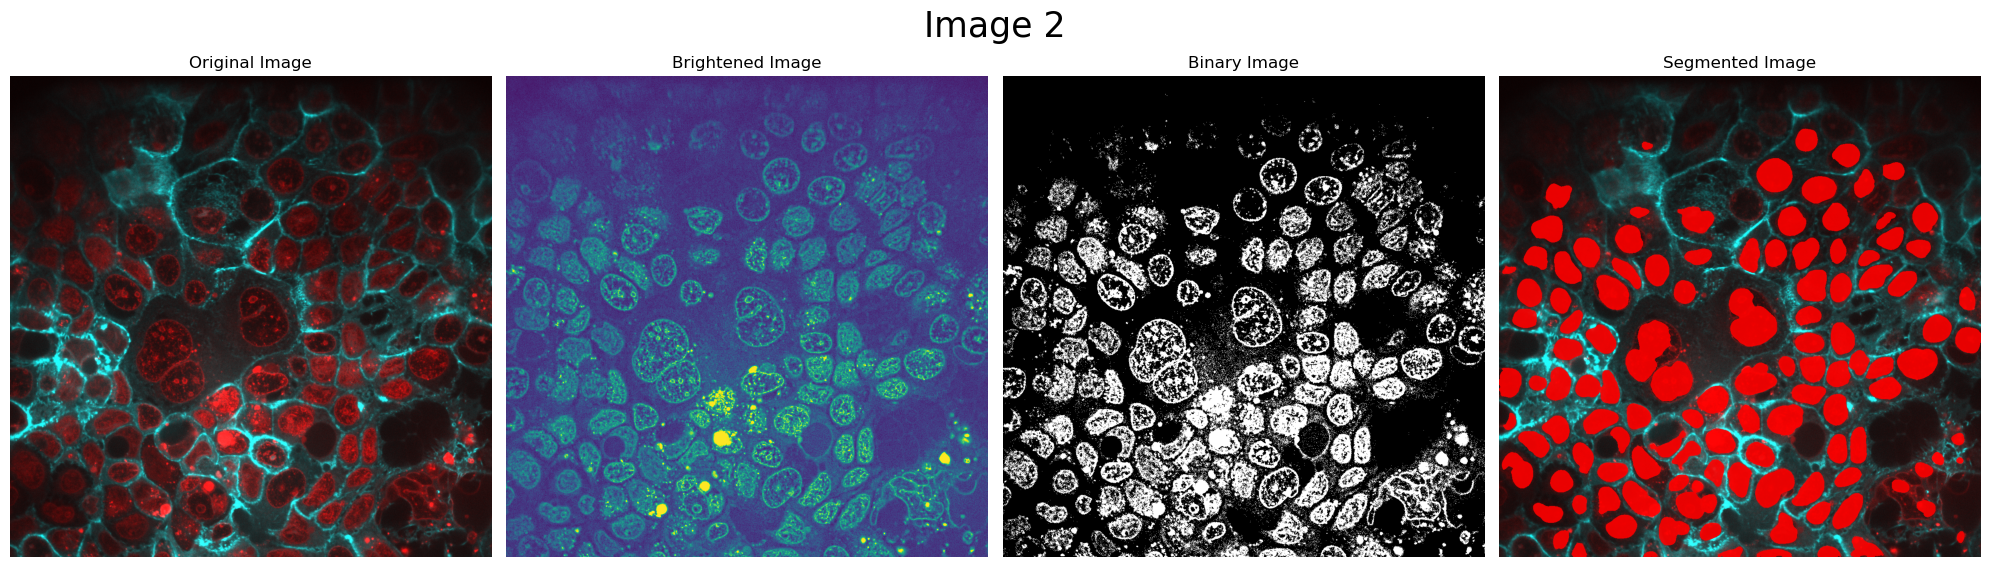

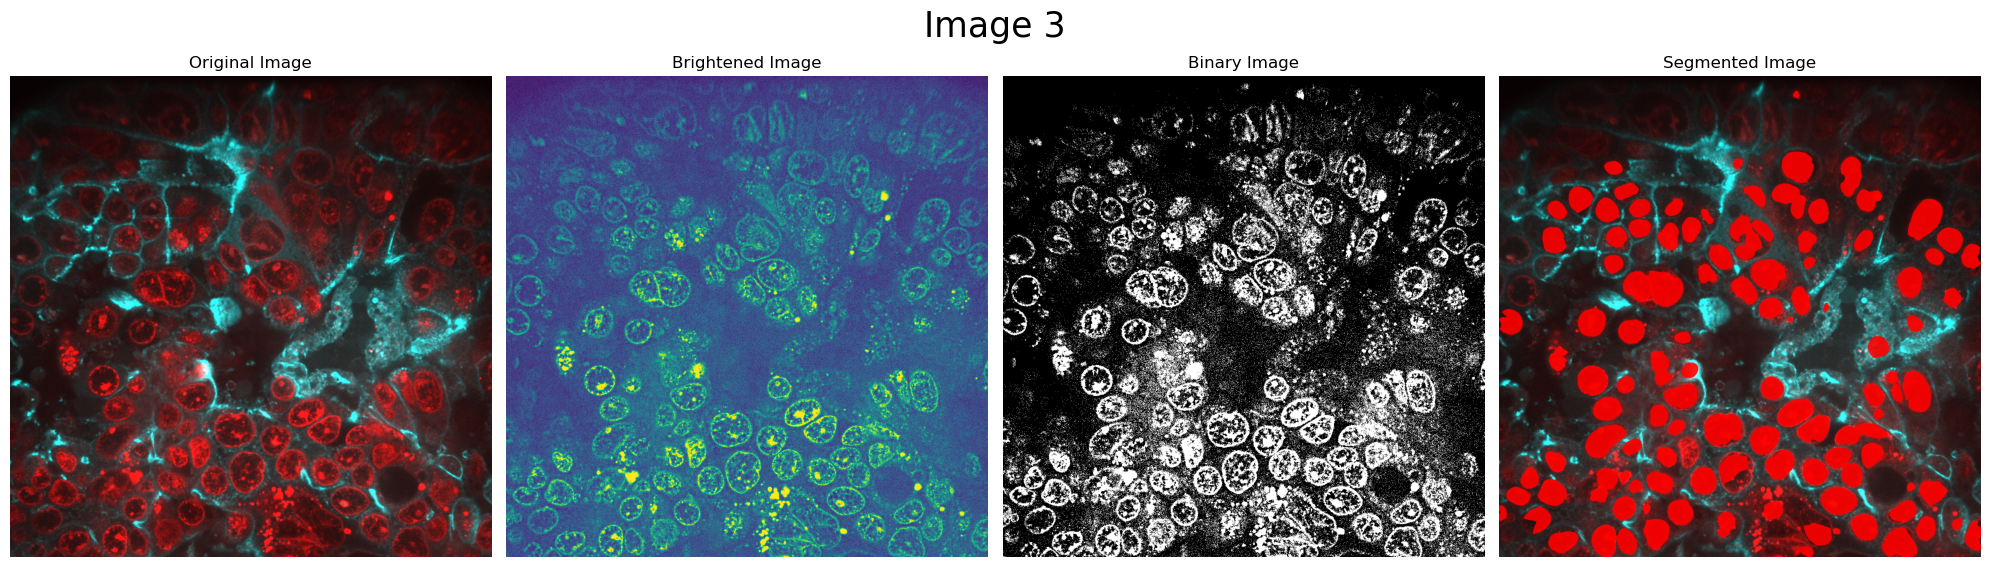

In [9]:
io.logger_setup()

#Model without and with denoising
# model = models.Cellpose(model_type='nuclei', gpu=True)

model = denoise.CellposeDenoiseModel(gpu=True, model_type="nuclei",
             restore_type='denoise_nuclei')

for i in range(len(Images)):
    #1.Isolating the red channel for each Image
    Red_channel = np.copy(Images[i][:, :, 0])

    # 2.1 Apply Histogram equalization 
    # hist, edges = np.histogram(Red_channel.flatten(), bins = 512, range = [0, 512])
    # CDF = compute_cdf(hist)
    # Red_channel = C(Red_channel, CDF)*255
    #2.2 Apply Adaptive Histogram equalization (play with kernal size and clip_limit), works better here
    Red_channel = skimage.exposure.equalize_adapthist(Red_channel, kernel_size=10, clip_limit=0.01, nbins=512)

    #3.Convert to binary using otsu
    threshold = filters.threshold_otsu(Red_channel)
    binary_image = Red_channel > threshold

    #4.Apply opening (not recommended)
    # selem = morphology.disk(1)
    # opened_image = morphology.opening(binary_image, selem)

    #5.Segmentation
    masks, flows, styles, diams = model.eval(binary_image, diameter=46, channels=[0, 0])

    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    ax = axes.ravel()

    ax[0].imshow(Images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(Red_channel)
    ax[1].set_title('Brightened Image')
    ax[2].imshow(binary_image, cmap='gray')
    ax[2].set_title('Binary Image')
    ax[3].imshow(Images[i])
    ax[3].imshow(masks, alpha = 0.9*(masks>0.01), cmap = custom_colormap())
    ax[3].set_title('Segmented Image')

    for a in ax:
        a.axis('off')
    plt.suptitle(f'Image {i + 1}', x = 0.5, y = 0.97, fontsize = 25)
    plt.tight_layout()
    plt.show()
    